In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from collections import defaultdict

# Exercise 11.7

Fit a neural network to the spam data of Section 9.1.2, and compare
the results to those for the additive model given in that chapter. Compare
both the classification performance and interpretability of the final model.

# Solution

Some useful functions for the notebook,

In [2]:
def standardize(X,X_test):
    
    mu = np.mean(X,axis=0)
    sig = np.std(X,axis=0)
    
    return (X-mu)/sig, (X_test-mu)/sig,

def cross_validation_split(X,y,K):
    N,_ = X.shape
    delta = N//K
    
    data_CV = []
    
    for i in range(K):
        
        X_train = np.concatenate((X[:i*delta],X[(i+1)*delta:]))
        y_train = np.concatenate((y[:i*delta],y[(i+1)*delta:]))
        
        X_val = X[i*delta:(i+1)*delta]
        y_val = y[i*delta:(i+1)*delta]
        
        data_CV.append((X_train,y_train,X_val,y_val))
        
    return data_CV

In [3]:
url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data'
df = pd.read_csv(url_link,sep=' ',header=None)

# Divide data in training and test sets
df_train = df.sample(frac=0.7,random_state=140590)
df_test = df.drop(index=df_train.index)

df.tail()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
4596,0.31,0.0,0.62,0.0,0.00,0.31,0.0,0.0,0.0,0.0,...,0.000,0.232,0.0,0.000,0.0,0.0,1.142,3,88,0
4597,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.353,0.0,0.0,1.555,4,14,0
4598,0.30,0.0,0.30,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.102,0.718,0.0,0.000,0.0,0.0,1.404,6,118,0
4599,0.96,0.0,0.00,0.0,0.32,0.00,0.0,0.0,0.0,0.0,...,0.000,0.057,0.0,0.000,0.0,0.0,1.147,5,78,0
4600,0.00,0.0,0.65,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.125,0.0,0.0,1.250,5,40,0


In [4]:
y = df_train.pop(57).to_numpy()
y_test = df_test.pop(57).to_numpy()

X, X_test = standardize(df_train.to_numpy(),df_test.to_numpy())

Let's use K-fold cross validation to select the size of the hidden layer,

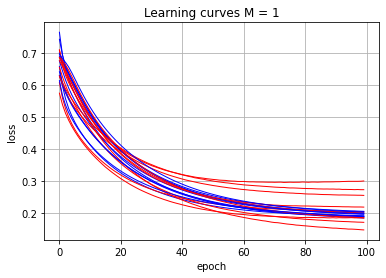

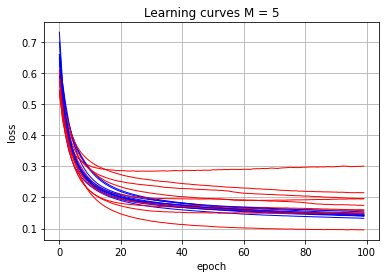

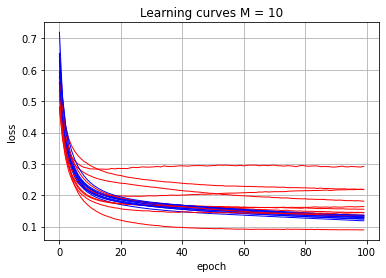

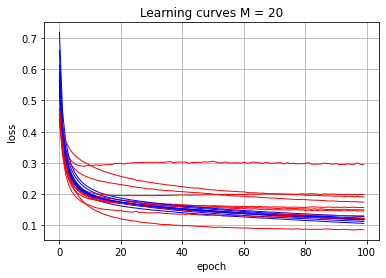

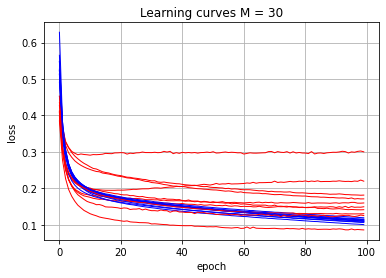

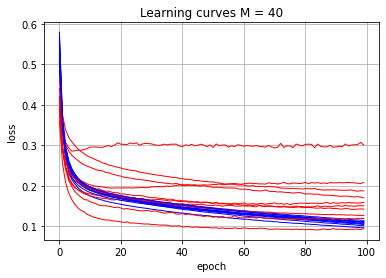

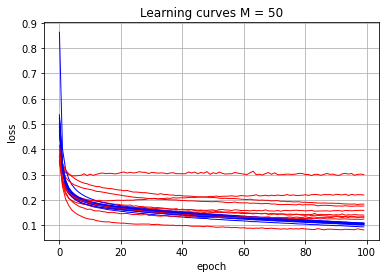

In [5]:
_,p = X.shape

# We use cross-validation to decide the size of the hidden layer
hidden_layer_sizes = [1,5,10,20,30,40,50]

rate = 1e-3  # Learning rate
K = 10       # Cross-validation split

accuracy = defaultdict(list)

for M in hidden_layer_sizes:

    train_accuracy = []
    val_accuracy = []

    for X_train,y_train,X_val,y_val in cross_validation_split(X,y,K):

        # Create simple NN with one hidden layer, output in logit form
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=(p,)))                      # Input layer
        model.add(tf.keras.layers.Dense(M,activation='sigmoid'))   # Hidden layer
        model.add(tf.keras.layers.Dense(1))                        # Output (logit, log p/1-p)

        # Compile model (loss is cross-entropy, metrics is accuracy from logit)
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=rate),
                      metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0)])

#         # Set a stopping point when the validation loss is not decreasing anymore
#         stop_fit = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

        history = model.fit(X_train,y_train,
                            epochs=100, 
                            verbose=False,
#                             callbacks=[stop_fit],
                            validation_data=(X_val,y_val)
                           )

        # Plot the 10 learning curves
        plt.plot(history.history['loss'],c='b',linewidth=1)
        plt.plot(history.history['val_loss'],c='r',linewidth=1)

        # Record the accuracy
        train_accuracy.append(history.history['binary_accuracy'][-1])
        val_accuracy.append(history.history['val_binary_accuracy'][-1])
        
    plt.title('Learning curves M = {}'.format(M))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.show()

    accuracy['train_accuracy'].append(np.mean(train_accuracy))
    accuracy['val_accuracy'].append(np.mean(val_accuracy))
    accuracy['std_error_val'].append(np.std(val_accuracy)/np.sqrt(K))

The accuracy as a function of the number of hidden nodes is,

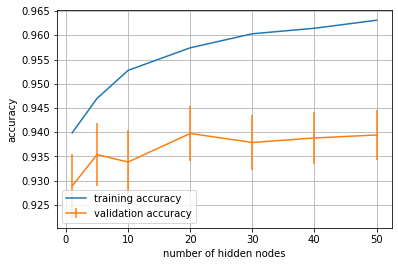

In [6]:
plt.plot(hidden_layer_sizes,accuracy['train_accuracy'],label='training accuracy')

plt.errorbar(hidden_layer_sizes,accuracy['val_accuracy'],
             yerr=accuracy['std_error_val'],
             label='validation accuracy'
            )
plt.xlabel('number of hidden nodes')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

If we use the one-standard-error rule, we can pick up M = 10, and run the training for approx 100 epoch (we do not gain much for running longer, as we see from the learning curves for cross validation).

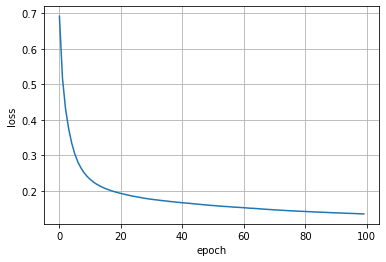

In [7]:
M_opt = 10
rate = 1e-3

# Simple NN with one hidden layer, output in logit form
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(p,)))                          # Input layer
model.add(tf.keras.layers.Dense(M_opt,activation='sigmoid'))   # Hidden layer
model.add(tf.keras.layers.Dense(1))                            # Output (logit, log p/1-p)

# Compile model (loss is cross-entropy, metrics is accuracy from logit)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=rate),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0)])

# Fit the data with the NN
history = model.fit(X,y,
                    epochs=100, 
                    verbose=False
                   )

# Plot the learning curve
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

In [8]:
N_test,_ = X_test.shape

y_predicted = np.zeros(N_test)
y_predicted[model.predict(X_test).flatten() > 0] = 1

test_error = np.mean(y_test != y_predicted)

print('Test error = {:.3f}'.format(test_error))

Test error = 0.068
